#Kaggle Kickstarter Projectでのロジスティック回帰

・KaggleURL
https://www.kaggle.com/kemical/kickstarter-projects

#目的
Kickstarter Project（クラウドファンディング）が成功するかどうかを分類できるモデルを生成する

#目標
分類のAccuracy目標を80%以上をクライアントから要求されたと仮定する

#全体の流れ
全体の流れは以下の通りとする
1. データセットを調べる
2. データの読み込み
3. 前処理を行う
4. 特徴量を選択する
5. モデルを学習・評価する
6. まとめ
7. 課題

# 戦略概要
* 事後でないと分からないデータは除く
* 文字列から数値化できる変数を生成する
* カテゴリなどの質的変数はダミー変数化する

# 1.データセットを調べる
---
## データセット ks-projects-201801.csv

  * ID：内部ID
  * name：プロジェクト名
  * cetegory：カテゴリー
  * main_category：メインカテゴリー
  * currency：使用する通貨
  * deadline：締切日
  * goal：ゴール金額
  * launched：開始日
  * pledged：契約金額
  * state：プロジェクトの状態
  * backers：後援者数
  * country：国
  * usd pledged：契約金額（ドル換算）
  * usd_pledged_real：実質契約金額（ドル換算）
  * usd_goal_real：ゴール金額（ドル換算）




In [1]:
# ライブラリのインポート
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数
from sklearn.preprocessing import StandardScaler

# 2.データの読み込み

In [2]:
df_ks = pd.read_csv("ks-projects-201801.csv")

# 要約統計量
df_ks.describe(include='all')

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,378657,378661,378661,378661,378661,3.786610e+05,378661,3.786610e+05,378661,378661.000000,378661,3.748640e+05,3.786610e+05,3.786610e+05
unique,NaN,375764,159,15,14,3164,NaN,378089,NaN,6,NaN,23,NaN,NaN,NaN
top,NaN,New EP/Music Development,Product Design,Film & Video,USD,2014-08-08,NaN,1970-01-01 01:00:00,NaN,failed,NaN,US,NaN,NaN,NaN
freq,NaN,41,22314,63585,295365,705,NaN,7,NaN,197719,NaN,292627,NaN,NaN,NaN
mean,1.074731e+09,NaN,NaN,NaN,NaN,NaN,4.908079e+04,NaN,9.682979e+03,NaN,105.617476,NaN,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,NaN,NaN,NaN,NaN,NaN,1.183391e+06,NaN,9.563601e+04,NaN,907.185035,NaN,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,NaN,NaN,NaN,NaN,NaN,1.000000e-02,NaN,0.000000e+00,NaN,0.000000,NaN,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,NaN,NaN,NaN,NaN,NaN,2.000000e+03,NaN,3.000000e+01,NaN,2.000000,NaN,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,NaN,NaN,NaN,NaN,NaN,5.200000e+03,NaN,6.200000e+02,NaN,12.000000,NaN,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,NaN,NaN,NaN,NaN,NaN,1.600000e+04,NaN,4.076000e+03,NaN,56.000000,NaN,3.034090e+03,4.050000e+03,1.550000e+04


In [3]:
# データの要約
df_ks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


**nameとusd pledged**に欠損値があることが分かる

#3.前処理を行う

データは378661行ある

stateをsuccessfulとfailedに絞り込み、sucessfulを1、failedを0とする'state_flag'を追加する

In [4]:
# stateの状態を調べる
print(df_ks['state'].value_counts())

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64


In [5]:
# stateがsuccessful,failのものに絞り込む
df_ks = df_ks[df_ks['state'].str.contains("success") | df_ks['state'].str.contains("failed")]

# steteがsuccessfulの場合1、failの場合0とする
df_ks['state_flg'] = df_ks['state'].apply(lambda x : 1 if x == "successful" else 0)

print(df_ks['state_flg'].value_counts())

0    197719
1    133956
Name: state_flg, dtype: int64


successfulが133956個、failedが197719個となっている

nameが使えるかどうかを検討するために**文字数(name_len)とsuccessfullの関係**をグラフ化する

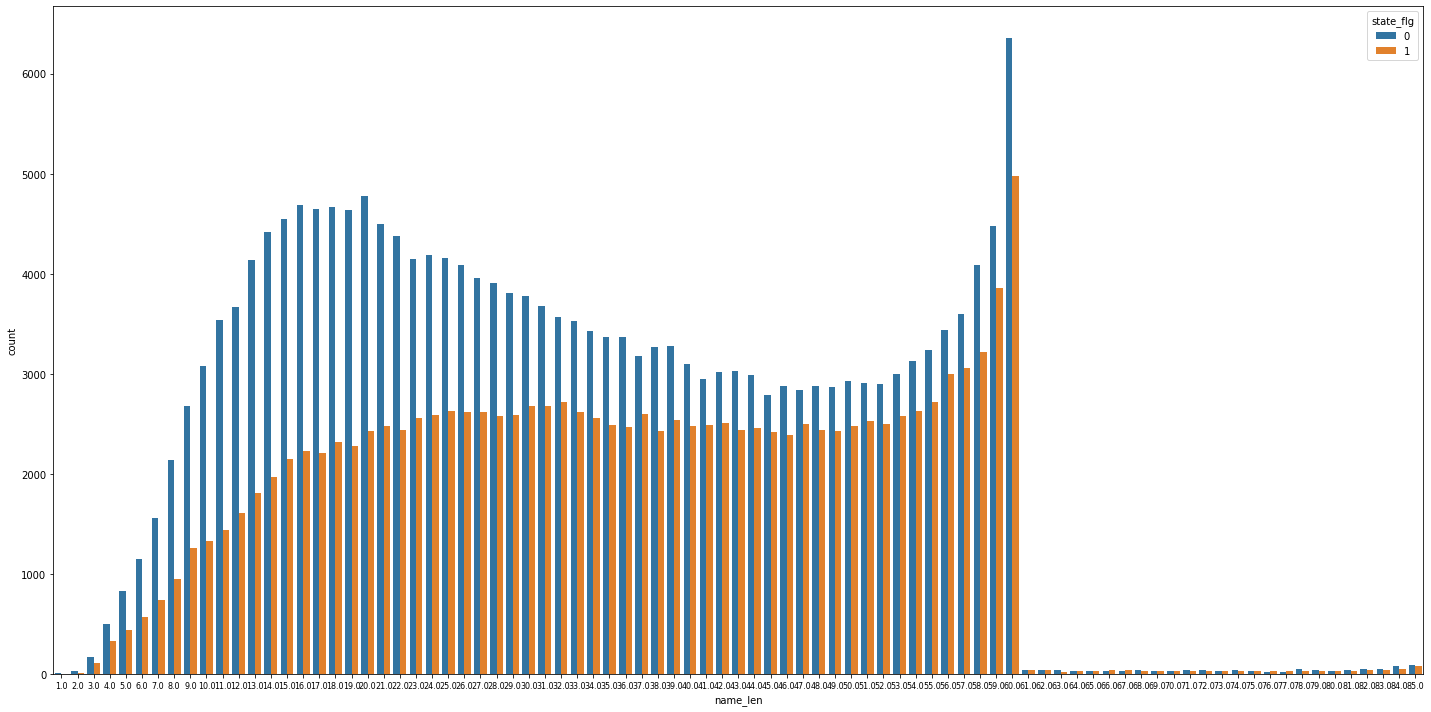

In [6]:
df_ks['name_len'] = df_ks.name.str.len()
plt.figure(figsize=(20,10))
ax = sns.countplot(data=df_ks, x='name_len',hue='state_flg')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
plt.tight_layout()
plt.show()

文字数が10文字～20文字あたりはfailedの比率が大きく、40文字以上ではあまり差が見られない

開始日と終了日から**期間(period)**を取得する

In [7]:
df_ks["period"] = (pd.to_datetime(df_ks.deadline) - pd.to_datetime(df_ks.launched)).dt.days
df_ks.period

0         58
1         59
2         44
3         29
5         34
          ..
378654    29
378657    26
378658    45
378659    30
378660    27
Name: period, Length: 331675, dtype: int64

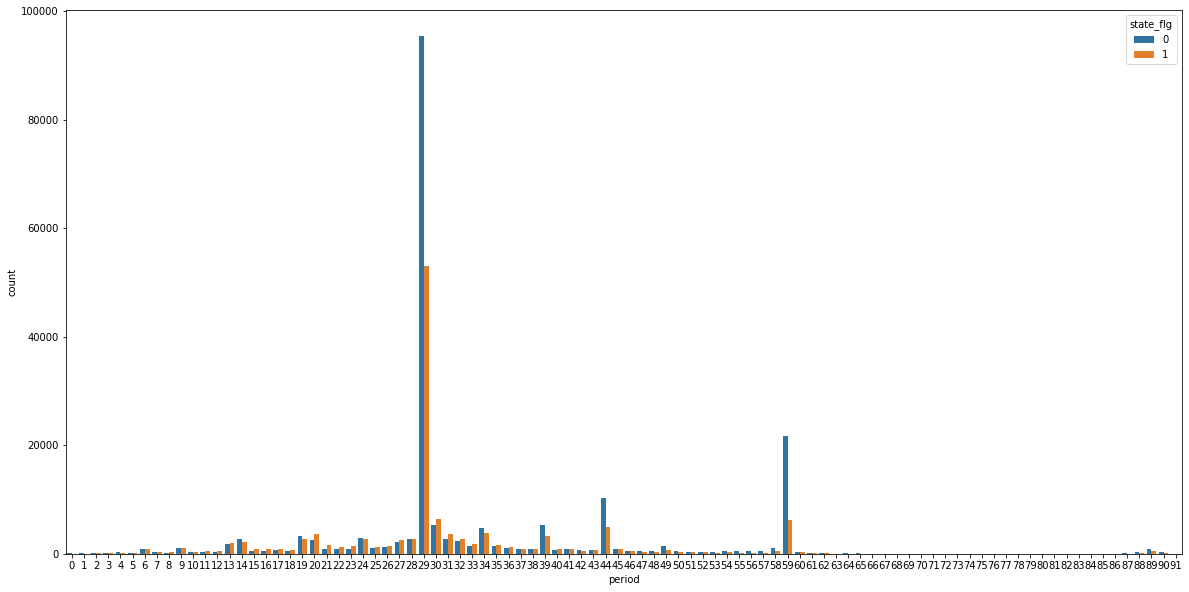

In [8]:
plt.figure(figsize=(20,10))
sns.countplot(data=df_ks, x='period',hue='state_flg')

期間periodとstate_flgの間にはあまり関連がありそうにない

開始日を年、月、日、時に分けて使用する

In [9]:
df_ks = df_ks.assign(hour=pd.to_datetime(df_ks.launched).dt.hour,
               day=pd.to_datetime(df_ks.launched).dt.day,
               month=pd.to_datetime(df_ks.launched).dt.month,
               year=pd.to_datetime(df_ks.launched).dt.year)
df_ks.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,state_flg,name_len,period,hour,day,month,year
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95,0,31.0,58,12,11,8,2015
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00,0,45.0,59,4,2,9,2017
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00,0,14.0,44,0,12,1,2013
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00,0,49.0,29,3,17,3,2012
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,successful,224,US,52375.0,52375.0,50000.00,1,20.0,34,13,26,2,2016


#4.特徴量を選択する
回帰に不要な列（事後でないと分からない項目、同義の項目）を削除する

## 削除理由
* ID：インデックスのため
* name：name_lenで文字数を使用する
* currency：countryと同義
* deadlineとlaunched：period（期間)に代替
* pledged,backers,usd pledged,usd_pledged_real：事後でないと分からない
* goal：usd_goal_realでドル換算でそろえたものを使用
* state：state_flgで代替





In [10]:
# 関連しない項目
# 後にならないと分からない項目

drop_idx = ['ID', 'name', 'currency', 'deadline', 'launched', 'pledged', 'state', 'backers', 'usd pledged', 'usd_pledged_real', 'goal']
df_ks = df_ks.drop(drop_idx, axis=1)

df_ks.head()

,category,main_category,country,usd_goal_real,state_flg,name_len,period,hour,day,month,year
0,Poetry,Publishing,GB,1533.95,0,31.0,58,12,11,8,2015
1,Narrative Film,Film & Video,US,30000.00,0,45.0,59,4,2,9,2017
2,Narrative Film,Film & Video,US,45000.00,0,14.0,44,0,12,1,2013
3,Music,Music,US,5000.00,0,49.0,29,3,17,3,2012
5,Restaurants,Food,US,50000.00,1,20.0,34,13,26,2,2016


文字列として、category,main_category,countryが残っている

In [11]:
# 欠損行を確認
df_ks.isnull().sum()

category         0
main_category    0
country          0
usd_goal_real    0
state_flg        0
name_len         3
period           0
hour             0
day              0
month            0
year             0
dtype: int64

In [12]:
# 欠損行を削除
df_ks = df_ks.dropna()
df_ks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331672 entries, 0 to 378660
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   category       331672 non-null  object 
 1   main_category  331672 non-null  object 
 2   country        331672 non-null  object 
 3   usd_goal_real  331672 non-null  float64
 4   state_flg      331672 non-null  int64  
 5   name_len       331672 non-null  float64
 6   period         331672 non-null  int64  
 7   hour           331672 non-null  int64  
 8   day            331672 non-null  int64  
 9   month          331672 non-null  int64  
 10  year           331672 non-null  int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 30.4+ MB


現在の項目での相関を確認する

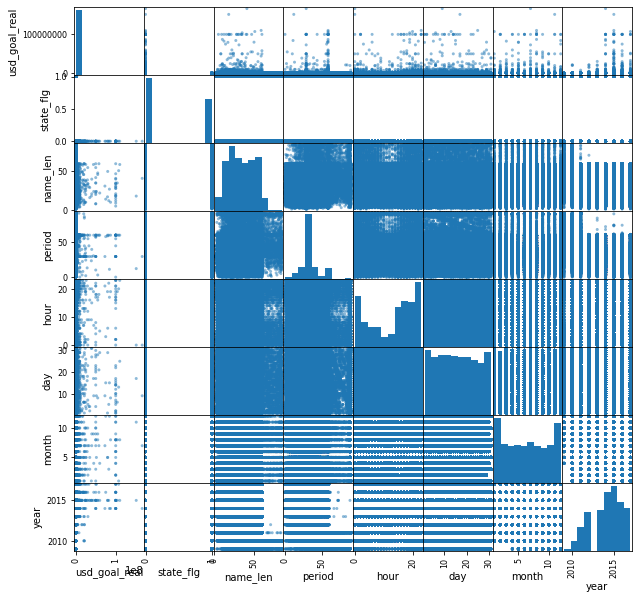

In [13]:
pd.plotting.scatter_matrix(df_ks, figsize=(10, 10))
plt.show()

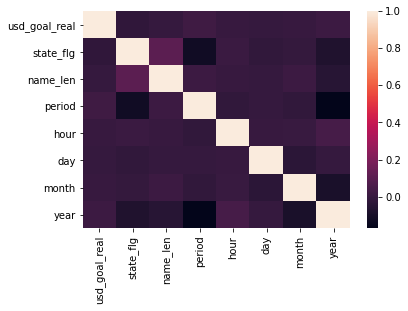

In [14]:
# 相関関係をヒートマップで確認
sns.heatmap(df_ks.corr())
plt.show()

* name_len、usd_goal_realはstate_flgと相関が少しありそうだが、periodは相関がみられない
* launchedを分割したhour、day、montyは相関がありそうだが、yearは相関が低い

文字列をダミー変数化して、説明変数として使用する

In [15]:
# 質的変数をダミー変数化
df_ks = pd.get_dummies(df_ks)
df_ks.head()

,usd_goal_real,state_flg,name_len,period,hour,day,month,year,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,category_Art,category_Art Books,category_Audio,category_Bacon,category_Blues,category_Calendars,category_Camera Equipment,category_Candles,category_Ceramics,category_Children's Books,category_Childrenswear,category_Chiptune,category_Civic Design,category_Classical Music,category_Comedy,category_Comic Books,category_Comics,category_Community Gardens,category_Conceptual Art,category_Cookbooks,category_Country & Folk,category_Couture,...,category_Young Adult,category_Zines,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,country_AT,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,country_ES,country_FR,country_GB,country_HK,country_IE,country_IT,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,1533.95,0,31.0,58,12,11,8,2015,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,30000.00,0,45.0,59,4,2,9,2017,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,45000.00,0,14.0,44,0,12,1,2013,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,5000.00,0,49.0,29,3,17,3,2012,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,50000.00,1,20.0,34,13,26,2,2016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [16]:
df_ks.describe()

,usd_goal_real,state_flg,name_len,period,hour,day,month,year,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,category_Art,category_Art Books,category_Audio,category_Bacon,category_Blues,category_Calendars,category_Camera Equipment,category_Candles,category_Ceramics,category_Children's Books,category_Childrenswear,category_Chiptune,category_Civic Design,category_Classical Music,category_Comedy,category_Comic Books,category_Comics,category_Community Gardens,category_Conceptual Art,category_Cookbooks,category_Country & Folk,category_Couture,...,category_Young Adult,category_Zines,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,country_AT,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,country_ES,country_FR,country_GB,country_HK,country_IE,country_IT,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
count,3.316720e+05,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.00000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.00000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,...,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000
mean,4.150966e+04,0.403881,34.220335,32.954889,13.087336,15.285421,6.416149,2014.180024,0.001713,0.002343,0.008261,0.001872,0.000690,0.006672,0.002222,0.018591,0.015940,0.001936,0.02257,0.007444,0.001094,0.000546,0.000706,0.000874,0.001055,0.00114,0.000829,0.018687,0.001260,0.000099,0.000802,0.007357,0.006235,0.007516,0.013812,0.000817,0.002804,0.001372,0.012702,0.000684,...,0.002141,0.001070,0.077305,0.029782,0.023571,0.010773,0.076473,0.059622,0.170427,0.066493,0.085989,0.012509,0.138537,0.029213,0.106868,0.081556,0.030880,0.001462,0.019947,0.001577,0.037296,0.001966,0.010360,0.002792,0.005647,0.007598,0.088802,0.001438,0.002059,0.007143,0.000069,0.000172,0.004254,0.000633,0.007269,0.001755,0.003841,0.004550,0.001369,0.788001
std,1.108935e+06,0.490675,15.961502,12.713279,7.715452,8.814433,3.306967,1.930916,0.041347,0.048345,0.090515,0.043230,0.026267,0.081411,0.047087,0.135074,0.125245,0.043953,0.14853,0.085958,0.033064,0.023354,0.026552,0.029557,0.032468,0.03374,0.028783,0.135418,0.035478,0.009974,0.028308,0.085455,0.078716,0.086371,0.116710,0.028573,0.052878,0.037013,0.111987,0.026152,...,0.046218,0.032699,0.267076,0.169987,0.151710,0.103231,0.265754,0.236786,0.376008,0.249143,0.280348,0.111144,0.345464,0.168402,0.308945,0.273688,0.172993,0.038212,0.139820,0.039678,0.189486,0.044294,0.101254,0.052765,0.074935,0.086834,0.284458,0.037896,0.045332,0.084212,0.008327,0.013108,0.065085,0.025155,0.084949,0.041853,0.061858,0.067298,0.036972,0.408724
min,1.000000e-02,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,2009.000000,0.000000

#5.モデルを学習・評価する

##ロジスティック回帰のみ

In [17]:
y = df_ks['state_flg'].values
X = df_ks.drop('state_flg', axis=1).values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=0, tol=1e-3)
clf.fit(X, y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log',
              max_iter=10000, n_iter_no_change=5, n_jobs=None, penalty='none',
              power_t=0.5, random_state=0, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [18]:
# 予測値
y_est = clf.predict(X)
# 確率値
y_est_proba = clf.predict_proba(X)

# 対数尤度を表示
# log_lossという関数は、負の対数尤度を返す
# normalizeという引数をTrueにすると、合計の対数尤度ではなく平均の対数尤度が計算される
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est_proba, normalize=False))) 
# 正答率を計算
accuracy =  accuracy_score(y, y_est)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

対数尤度 = -4476018.188
正答率（Accuracy） = 60.927%
適合率（Precision） = 55.331%
再現率（Recall） = 16.898%
F1値（F1-score） = 25.890%


In [19]:
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['実績 failed', '実績 successful'], 
                        columns=['予測 failed', '予測 successful'])
conf_mat

,予測 failed,予測 successful
実績 failed,179442,18274
実績 successful,111320,22636


# ロジスティック回帰＋標準化

In [20]:
std_scaler = StandardScaler() 

# fit_transform関数で標準化した特徴量X_scaledを得る
X_scaled = std_scaler.fit_transform(X)

clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=0, tol=1e-3)
clf.fit(X_scaled, y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log',
              max_iter=10000, n_iter_no_change=5, n_jobs=None, penalty='none',
              power_t=0.5, random_state=0, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

ロジスティック回帰＋標準化モデルを評価する

In [21]:
# 予測値
y_est = clf.predict(X_scaled)
# 確率値
y_est_proba = clf.predict_proba(X_scaled)

# 対数尤度を表示
# log_lossという関数は、負の対数尤度を返す
# normalizeという引数をTrueにすると、合計の対数尤度ではなく平均の対数尤度が計算される
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est_proba, normalize=False))) 
# 正答率を計算
accuracy =  accuracy_score(y, y_est)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

対数尤度 = -204739.069
正答率（Accuracy） = 67.300%
適合率（Precision） = 60.617%
再現率（Recall） = 54.343%
F1値（F1-score） = 57.309%


In [22]:
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['実績 failed', '実績 successful'], 
                        columns=['予測 failed', '予測 successful'])
conf_mat

,予測 failed,予測 successful
実績 failed,150420,47296
実績 successful,61160,72796


#ロジスティック回帰＋標準化+L1正規化

上記に加え、正規化を行う

In [23]:
clf = SGDClassifier(loss='log', penalty='l1', max_iter=10000, fit_intercept=True, random_state=0, tol=1e-3)
clf.fit(X_scaled, y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log',
              max_iter=10000, n_iter_no_change=5, n_jobs=None, penalty='l1',
              power_t=0.5, random_state=0, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [24]:
# 予測値
y_est = clf.predict(X_scaled)
# 確率値
y_est_proba = clf.predict_proba(X_scaled)

# 対数尤度を表示
# log_lossという関数は、負の対数尤度を返す
# normalizeという引数をTrueにすると、合計の対数尤度ではなく平均の対数尤度が計算される
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est_proba, normalize=False))) 
# 正答率を計算
accuracy =  accuracy_score(y, y_est)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

対数尤度 = -200387.817
正答率（Accuracy） = 67.359%
適合率（Precision） = 61.467%
再現率（Recall） = 51.409%
F1値（F1-score） = 55.990%


In [25]:
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['実績 failed', '実績 successful'], 
                        columns=['予測 failed', '予測 successful'])
conf_mat

,予測 failed,予測 successful
実績 failed,154544,43172
実績 successful,65090,68866


#ロジスティック回帰＋標準化+L2正規化

L2正規化と比較してみる

In [26]:
clf = SGDClassifier(loss='log', penalty='l2', max_iter=10000, fit_intercept=True, random_state=0, tol=1e-3)
clf.fit(X_scaled, y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log',
              max_iter=10000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=0, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [27]:
# 予測値
y_est = clf.predict(X_scaled)
# 確率値
y_est_proba = clf.predict_proba(X_scaled)

# 対数尤度を表示
# log_lossという関数は、負の対数尤度を返す
# normalizeという引数をTrueにすると、合計の対数尤度ではなく平均の対数尤度が計算される
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est_proba, normalize=False))) 
# 正答率を計算
accuracy =  accuracy_score(y, y_est)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

対数尤度 = -203028.597
正答率（Accuracy） = 66.039%
適合率（Precision） = 60.387%
再現率（Recall） = 46.259%
F1値（F1-score） = 52.387%


In [28]:
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['実績 failed', '実績 successful'], 
                        columns=['予測 failed', '予測 successful'])
conf_mat

,予測 failed,予測 successful
実績 failed,157066,40650
実績 successful,71989,61967


##ロジスティック回帰＋標準化+L1正規化＋ホールドアウト法

更にホールドアウト法で汎化誤差を評価する


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1)

clf = SGDClassifier(loss='log', penalty='l1', max_iter=1, fit_intercept=True, random_state=0, tol=1e-3)
clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1,
              n_iter_no_change=5, n_jobs=None, penalty='l1', power_t=0.5,
              random_state=0, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

学習データに対する予測と評価

In [30]:
# 学習データに対する予測
y_est = clf.predict(X_train)
# 確率値
y_est_proba = clf.predict_proba(X_train)

# 対数尤度を表示
# log_lossという関数は、負の対数尤度を返す
# normalizeという引数をTrueにすると、合計の対数尤度ではなく平均の対数尤度が計算される
print('対数尤度 = {:.3f}'.format(- log_loss(y_train, y_est_proba, normalize=False))) 
# 正答率を計算
accuracy =  accuracy_score(y_train, y_est)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, y_est)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

対数尤度 = -202265.615
正答率（Accuracy） = 64.286%
適合率（Precision） = 55.608%
再現率（Recall） = 57.480%
F1値（F1-score） = 56.529%


テストデータに対する予測と評価

In [31]:
# テストデータに対する予測
y_est = clf.predict(X_test)
# 確率値
y_est_proba = clf.predict_proba(X_test)

# 対数尤度を表示
# log_lossという関数は、負の対数尤度を返す
# normalizeという引数をTrueにすると、合計の対数尤度ではなく平均の対数尤度が計算される
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_est_proba, normalize=False))) 
# 正答率を計算
accuracy =  accuracy_score(y_test, y_est)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_est)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

対数尤度 = -51125.970
正答率（Accuracy） = 63.954%
適合率（Precision） = 55.137%
再現率（Recall） = 57.248%
F1値（F1-score） = 56.172%


# 6.まとめ




ロジスティック回帰のみ
* 対数尤度 = -4476018.188
* 正答率（Accuracy） = 60.927%
* 適合率（Precision） = 55.331%
* 再現率（Recall） = 16.898%
* F1値（F1-score） = 25.890%

ロジスティック回帰＋標準化
* 対数尤度 = -204739.069
* 正答率（Accuracy） = 67.300%
* 適合率（Precision） = 60.617%
* 再現率（Recall） = 54.343%
* F1値（F1-score） = 57.309%

ロジスティック回帰＋標準化＋L1正規化
* 対数尤度 = -200387.817
* 正答率（Accuracy） = 67.359%
* 適合率（Precision） = 61.467%
* 再現率（Recall） = 51.409%
* F1値（F1-score） = 55.990%

ロジスティック回帰＋標準化＋L2正規化
* 対数尤度 = -203028.597
* 正答率（Accuracy） = 66.039%
* 適合率（Precision） = 60.387%
* 再現率（Recall） = 46.259%
* F1値（F1-score） = 52.387%

ロジスティック回帰＋標準化+L1正規化＋ホールドアウト法
* 学習データ
 * 対数尤度 = -202265.615
 * 正答率（Accuracy） = 64.286%
 * 適合率（Precision） = 55.608%
 * 再現率（Recall） = 57.480%
 * F1値（F1-score） = 56.529%

* テストデータ
 * 対数尤度 = -51125.970
 * 正答率（Accuracy） = 63.954%
 * 適合率（Precision） = 55.137%
 * 再現率（Recall） = 57.248%
 * F1値（F1-score） = 56.172%

上記の結果、**ロジスティック回帰＋標準化＋L1正規化のAccuracyが67.359%**と最も高くなった

さらにホールドアウト法で汎化誤差も学習データとテストデータでの**Accuracyの差が0.332%**と小さいことから過学習の可能性も低い

# 7.課題

Accuracy目標の80％に対して、約16％不足している

さらにAccuracyを上げるためには、以下の方法を今後検討していく

* ロジスティック回帰以外のモデルで学習する
* データ量をサンプリングしてSVMモデルで学習する
* 新たな特徴量を追加する(単語数、国ごとの特性、ゴール金額ごとのカテゴリ分け）



# SVMでの学習、評価

データ数が多すぎると終わらないため、データのサンプリングが必要

In [32]:
# データ数をサンプリングして減らす
ds_sample = df_ks.sample(frac=0.01, random_state=0)

y_sample = ds_sample['state_flg'].values
X_sample = ds_sample.drop('state_flg', axis=1).values

In [33]:
std_scaler = StandardScaler() 

# fit_transform関数で標準化した特徴量X_scaledを得る
X_scaled = std_scaler.fit_transform(X_sample)

In [34]:
# SVMの実行
C = 5
kernel = "rbf"
gamma = 1
clf = SVC(C=C, kernel=kernel, gamma=gamma)
clf.fit(X_scaled, y_sample)

SVC(C=5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [35]:
y_est = clf.predict(X_scaled)

print('対数尤度 = {:.3f}'.format(- log_loss(y_sample, y_est)))

print('正答率 = {:.3f}'.format(100* accuracy_score(y_sample, y_est)))

対数尤度 = -0.010
正答率 = 99.970


In [36]:
conf_mat = pd.DataFrame(confusion_matrix(y_sample, y_est), 
                        index=['実績 failed', '実績 successful'], 
                        columns=['予測 failed', '予測 successful'])
conf_mat

,予測 failed,予測 successful
実績 failed,1946,0
実績 successful,1,1370


In [37]:
# 正答率を計算
accuracy =  accuracy_score(y_sample, y_est)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_sample, y_est)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

正答率（Accuracy） = 99.970%
適合率（Precision） = 100.000%
再現率（Recall） = 99.927%
F1値（F1-score） = 99.964%


0.01％のデータ数では９９％の正答率になったが、データ数を増やすと学習が終わらないため今後検討する